In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

tsunami_dataset = "Tsunami.csv"

In [76]:
tsunami_df = pd.read_csv(tsunami_dataset)

tsunami_df = tsunami_df[
    [
        "Year",
        "Mo",
        "Dy",
        "Hr",
        "Mn",
        "Sec",
        "Tsunami Event Validity",
        "Tsunami Cause Code",
        "Earthquake Magnitude",
        "Vol",
        "Latitude",
        "Longitude",
        "Country",
        "Location Name",
        "Maximum Water Height (m)",
        "Number of Runups",
        "Tsunami Magnitude (Abe)",
        "Tsunami Magnitude (Iida)",
    ]
].dropna(
    subset=[
        "Year",
        "Mo",
        "Dy",
        "Hr",
        "Mn",
        "Sec",
        "Tsunami Event Validity",
        "Earthquake Magnitude",
        "Latitude",
        "Longitude",
    ]
)

print("Preprocessed DataFrame shape:", tsunami_df.shape)

Preprocessed DataFrame shape: (1025, 18)


Number of Runups Statistics:
count    1025.000000
mean       26.932683
std       225.298999
min         0.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      6421.000000
Name: Number of Runups, dtype: float64


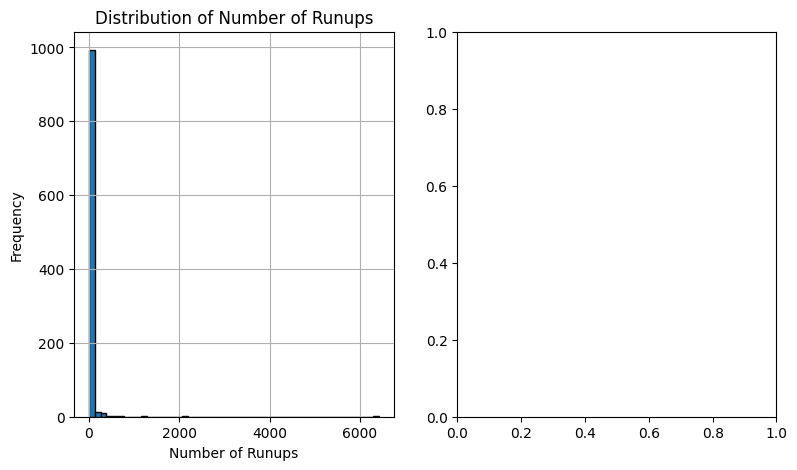

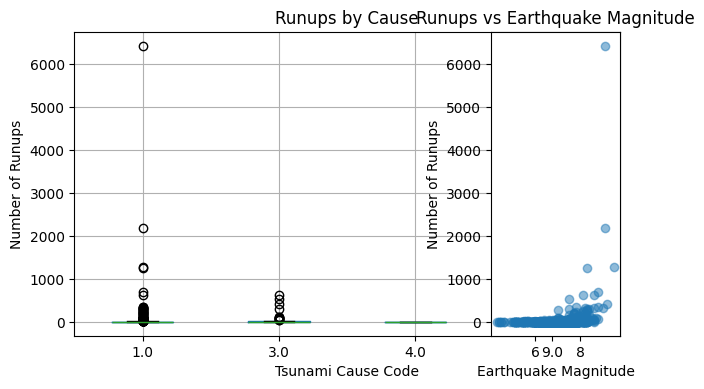

In [ ]:
print("Number of Runups Statistics:")
print(tsunami_df["Number of Runups"].describe())

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
tsunami_df["Number of Runups"].hist(bins=50, edgecolor="black")
plt.xlabel("Number of Runups")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Runups")

plt.subplot(1, 3, 2)
tsunami_df.boxplot(column="Number of Runups", by="Tsunami Cause Code")
plt.xlabel("Tsunami Cause Code")
plt.ylabel("Number of Runups")
plt.title("Runups by Cause")
plt.suptitle("")

plt.subplot(1, 3, 3)
plt.scatter(
    tsunami_df["Earthquake Magnitude"], tsunami_df["Number of Runups"], alpha=0.5
)
plt.xlabel("Earthquake Magnitude")
plt.ylabel("Number of Runups")
plt.title("Runups vs Earthquake Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
tsunami_df["Eq_Magnitude_Squared"] = tsunami_df["Earthquake Magnitude"] ** 2
tsunami_df["Abs_Latitude"] = np.abs(tsunami_df["Latitude"])
tsunami_df["Coastal_Distance"] = np.sqrt(
    tsunami_df["Latitude"] ** 2 + tsunami_df["Longitude"] ** 2
)
tsunami_df["Is_Earthquake_Related"] = (
    tsunami_df["Tsunami Cause Code"].isin([1, 2, 3, 4, 5]).astype(int)
)
tsunami_df["Is_Volcanic"] = (
    tsunami_df["Tsunami Cause Code"].isin([4, 5, 6, 7]).astype(int)
)
tsunami_df["Decade"] = (tsunami_df["Year"] // 10) * 10
tsunami_df["Is_Pacific_Ring"] = (
    (tsunami_df["Latitude"].between(10, 60))
    & (
        tsunami_df["Longitude"].between(120, 180)
        | tsunami_df["Longitude"].between(-180, -100)
    )
).astype(int)

features = [
    "Year",
    "Mo",
    "Dy",
    "Hr",
    "Mn",
    "Sec",
    "Tsunami Event Validity",
    "Tsunami Cause Code",
    "Earthquake Magnitude",
    "Vol",
    "Latitude",
    "Longitude",
    "Eq_Magnitude_Squared",
    "Abs_Latitude",
    "Coastal_Distance",
    "Is_Earthquake_Related",
    "Is_Volcanic",
    "Decade",
    "Is_Pacific_Ring",
]

X = tsunami_df[features].fillna(0)
y = np.log1p(tsunami_df["Number of Runups"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (820, 19)
Test set: (205, 19)


In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
}

print("Tuning Random Forest...")
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)
rf_grid.fit(X_train, y_train)
rf_tuned = rf_grid.best_estimator_

print("\nTuning Gradient Boosting...")
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)
gb_grid.fit(X_train, y_train)
gb_tuned = gb_grid.best_estimator_

print("\nBest RF params:", rf_grid.best_params_)
print("Best GB params:", gb_grid.best_params_)

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best GB params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}

Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best GB params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
ensemble = VotingRegressor([("rf", rf_tuned), ("gb", gb_tuned)])
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEnsemble Model Performance:")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE (log): {rmse:.4f}")
print(f"  MAE (log): {mae:.4f}")
print(f"\nOriginal Scale:")
print(
    f"  RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred_original)):.2f} runups"
)
print(f"  MAE: {mean_absolute_error(y_test_original, y_pred_original):.2f} runups")


Ensemble Model Performance:
  R² Score: 0.4972
  RMSE (log): 0.8291
  MAE (log): 0.6019

Original Scale:
  RMSE: 26.66 runups
  MAE: 8.51 runups


Top 10 Features:
                   feature  importance
12    Eq_Magnitude_Squared    0.233463
6   Tsunami Event Validity    0.211595
8     Earthquake Magnitude    0.195197
0                     Year    0.081665
10                Latitude    0.047110
11               Longitude    0.040010
14        Coastal_Distance    0.032265
13            Abs_Latitude    0.027406
5                      Sec    0.026828
2                       Dy    0.022239


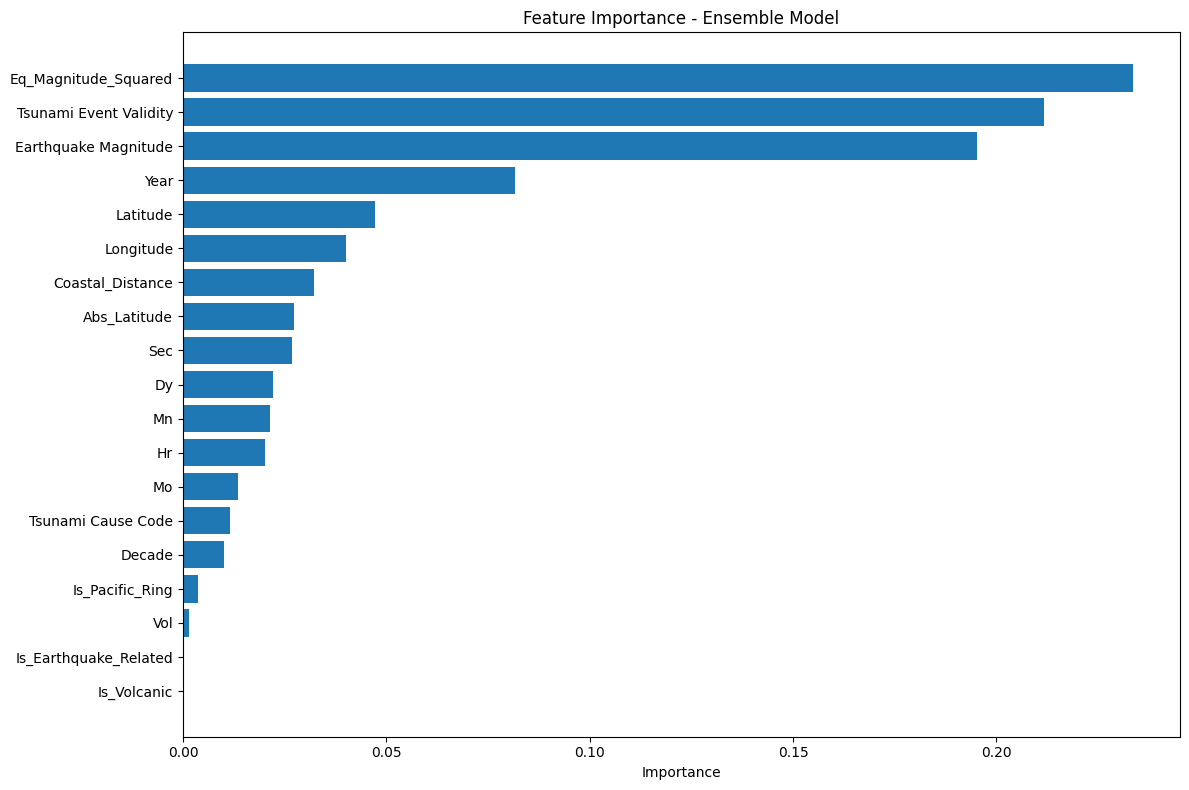

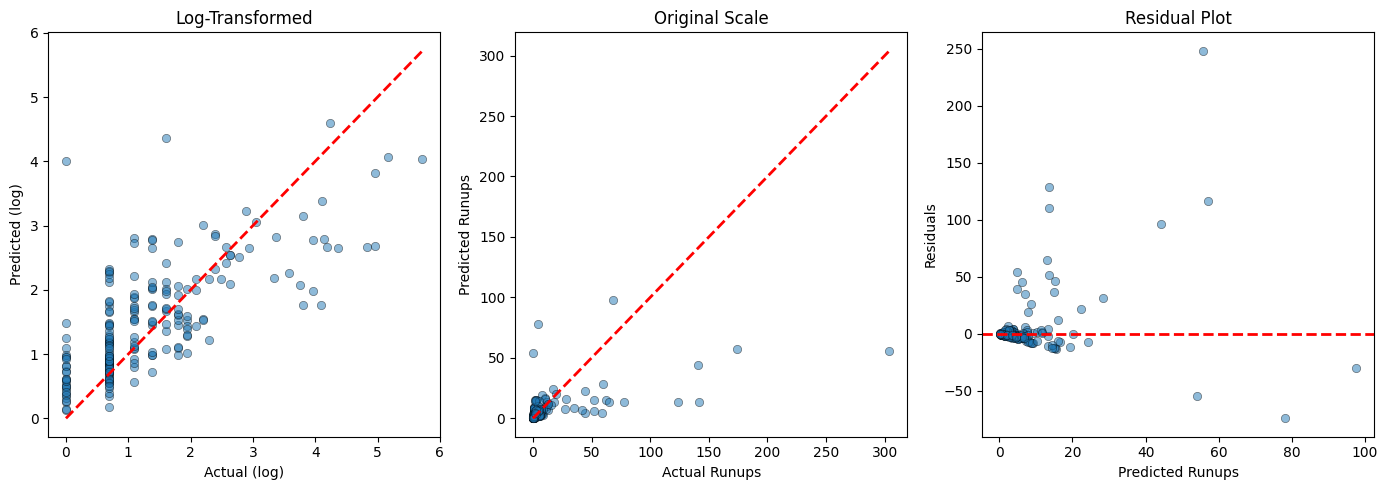


Model Summary:
  Explains 49.7% of variance
  Average error: ±8.5 runups


In [ ]:
feature_importance = pd.DataFrame(
    {
        "feature": features,
        "importance": (rf_tuned.feature_importances_ + gb_tuned.feature_importances_)
        / 2,
    }
).sort_values("importance", ascending=False)

print("Top 10 Features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance - Ensemble Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
plt.title("Log-Transformed")

plt.subplot(1, 3, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.plot([0, y_test_original.max()], [0, y_test_original.max()], "r--", lw=2)
plt.xlabel("Actual Runups")
plt.ylabel("Predicted Runups")
plt.title("Original Scale")

plt.subplot(1, 3, 3)
residuals = y_test_original - y_pred_original
plt.scatter(y_pred_original, residuals, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.axhline(y=0, color="r", linestyle="--", lw=2)
plt.xlabel("Predicted Runups")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()

print(f"\nModel Summary:")
print(f"  Explains {r2*100:.1f}% of variance")
print(
    f"  Average error: ±{mean_absolute_error(y_test_original, y_pred_original):.1f} runups"
)